# 📊 Financial Market Analysis Dashboard

In [1]:
import os
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

%matplotlib inline
sns.set(style="whitegrid")

TICKERS = ["AAPL", "MSFT", "GOOGL", "SPY"]
START_DATE = "2020-01-01"
END_DATE = "2024-07-31"
DATA_DIR = "data"
PLOTS_DIR = "plots"
RISK_FREE_RATE = 0.01

os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)


## Download and Prepare Stock Data

In [2]:
data = {}
successful_downloads = []
failed_downloads = []

for ticker in TICKERS:
    print(f"Downloading {ticker}...")
    try:
        df = yf.Ticker(ticker).history(start=START_DATE, end=END_DATE, auto_adjust=True)
        if df.empty or 'Close' not in df.columns:
            raise ValueError("No data or missing 'Close' column")
        close_prices = df['Close'].dropna()
        if len(close_prices) < 100:
            raise ValueError(f"Insufficient data ({len(close_prices)} points)")
        data[ticker] = close_prices
        df.to_csv(f"{DATA_DIR}/{ticker}.csv")
        successful_downloads.append(ticker)
    except Exception as e:
        print(f"Failed {ticker}: {e}")
        failed_downloads.append(ticker)

if len(data) < 2:
    backup_tickers = ["TSLA", "AMZN", "NVDA", "META"]
    for t in backup_tickers:
        if len(data) >= 4:
            break
        try:
            df = yf.Ticker(t).history(start="2022-01-01", end=END_DATE, auto_adjust=True)
            if not df.empty and 'Close' in df.columns:
                close_prices = df['Close'].dropna()
                if len(close_prices) >= 100:
                    data[t] = close_prices
                    df.to_csv(f"{DATA_DIR}/{t}.csv")
        except:
            continue


## 📊 Combine and Clean Data

In [3]:
combined_df = pd.DataFrame(data).dropna()
if combined_df.empty or len(combined_df) < 50:
    combined_df = pd.DataFrame(data).fillna(method='ffill').fillna(method='bfill').dropna()
returns_df = combined_df.pct_change().dropna()


## Financial Metrics Calculation

In [4]:
def calculate_metrics(returns_df, prices_df, risk_free_rate=0.01):
    metrics = {}
    for ticker in returns_df.columns:
        r = returns_df[ticker]
        price_series = prices_df[ticker]
        vol = r.std() * np.sqrt(252)
        ret = r.mean() * 252
        sharpe = (ret - risk_free_rate) / vol
        max_dd = ((price_series / price_series.expanding().max()) - 1).min()
        metrics[ticker] = {
            'Annual_Return': ret,
            'Volatility': vol,
            'Sharpe_Ratio': sharpe,
            'Max_Drawdown': max_dd
        }
    return pd.DataFrame(metrics).T

metrics_df = calculate_metrics(returns_df, combined_df, RISK_FREE_RATE)

if 'SPY' in returns_df.columns:
    spy_returns = returns_df['SPY']
    metrics_df['Beta_vs_SPY'] = [
        np.cov(returns_df[t], spy_returns)[0][1] / np.var(spy_returns)
        if t != 'SPY' else np.nan for t in returns_df.columns
    ]


## Correlation Matrix

In [5]:
correlation_matrix = returns_df.corr()

## Visualizations

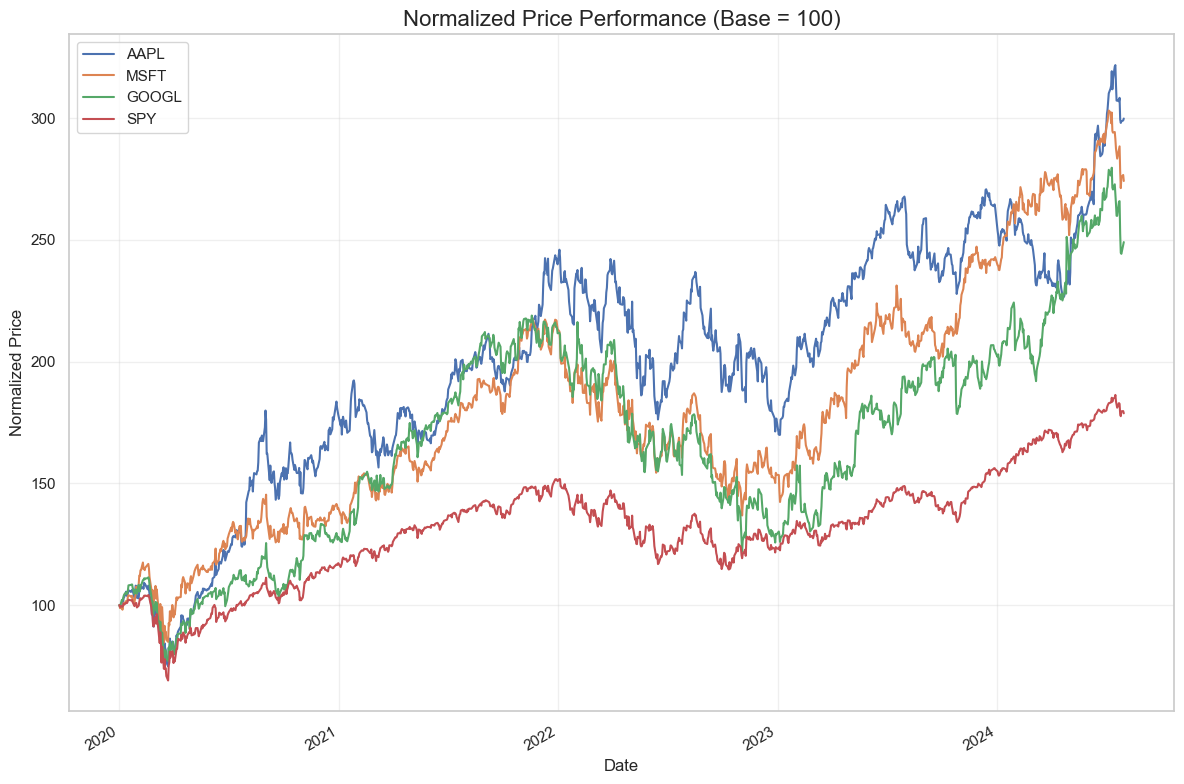

In [6]:
plt.figure(figsize=(12, 8))
norm_prices = combined_df / combined_df.iloc[0] * 100
norm_prices.plot(ax=plt.gca())
plt.title('Normalized Price Performance (Base = 100)', fontsize=16)
plt.ylabel('Normalized Price')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{PLOTS_DIR}/price_performance.png")
plt.show()


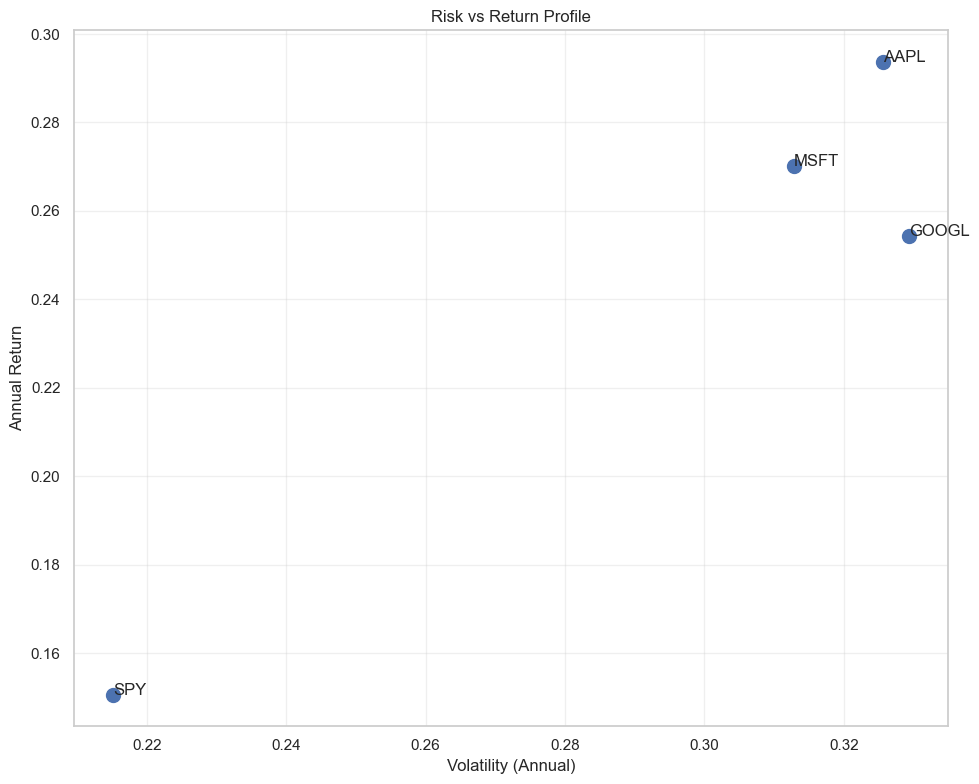

In [7]:
plt.figure(figsize=(10, 8))
plt.scatter(metrics_df['Volatility'], metrics_df['Annual_Return'], s=100)

for t in metrics_df.index:
    plt.annotate(t, (metrics_df.loc[t, 'Volatility'], metrics_df.loc[t, 'Annual_Return']))

plt.xlabel('Volatility (Annual)')
plt.ylabel('Annual Return')
plt.title('Risk vs Return Profile')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{PLOTS_DIR}/risk_return.png")
plt.show()


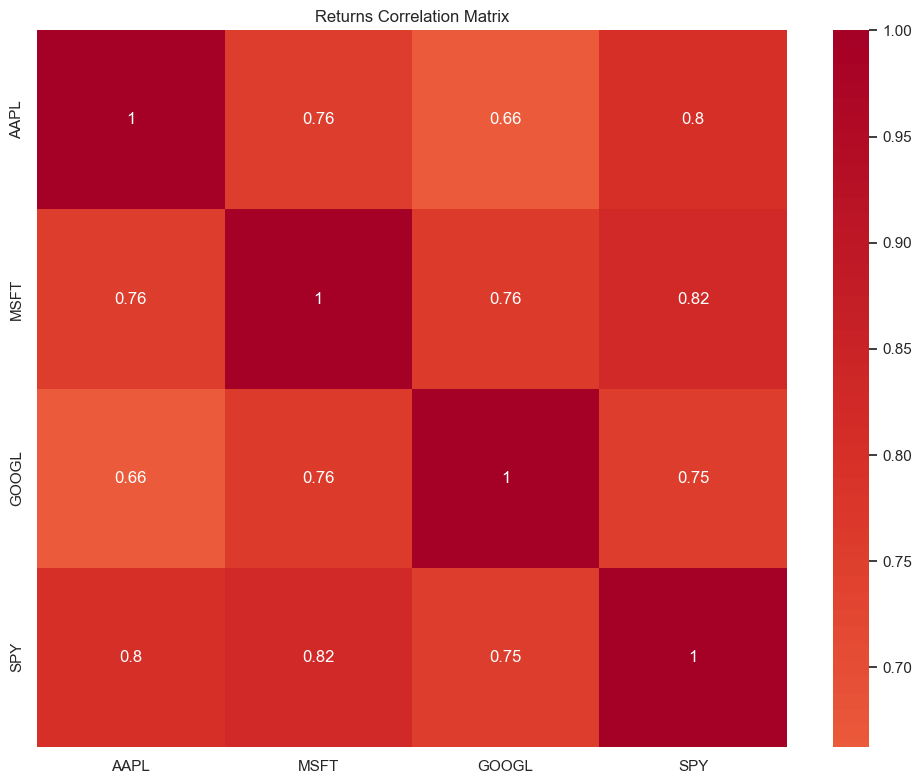

In [8]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlBu_r', center=0)
plt.title('Returns Correlation Matrix')
plt.tight_layout()
plt.savefig(f"{PLOTS_DIR}/correlation_heatmap.png")
plt.show()


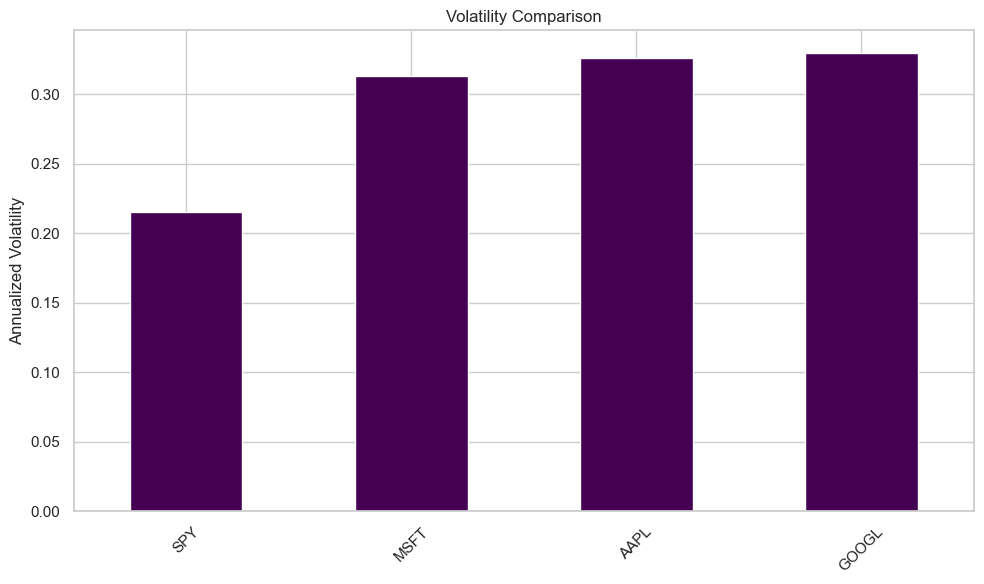

In [9]:
plt.figure(figsize=(10, 6))
vols = metrics_df['Volatility'].sort_values()
vols.plot(kind='bar', colormap='viridis')
plt.title('Volatility Comparison')
plt.ylabel('Annualized Volatility')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"{PLOTS_DIR}/volatility_comparison.png")
plt.show()


In [10]:
combined_df.to_csv("data/combined_prices.csv")
returns_df.to_csv("data/returns.csv")
metrics_df.to_csv("data/metrics.csv")
correlation_matrix.to_csv("data/correlation_matrix.csv")

with open("data/analysis_summary.txt", 'w') as f:
    f.write("STOCK MARKET ANALYSIS SUMMARY\n")
    f.write("=" * 50 + "\n")
    f.write(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Period: {combined_df.index.min().date()} to {combined_df.index.max().date()}\n")
    f.write(f"Stocks: {', '.join(combined_df.columns)}\n\n")
    for t in metrics_df.index:
        f.write(f"{t}\n")
        f.write(f"  Annual Return: {metrics_df.loc[t, 'Annual_Return']:.2%}\n")
        f.write(f"  Volatility: {metrics_df.loc[t, 'Volatility']:.2%}\n")
        f.write(f"  Sharpe Ratio: {metrics_df.loc[t, 'Sharpe_Ratio']:.2f}\n")
        f.write(f"  Max Drawdown: {metrics_df.loc[t, 'Max_Drawdown']:.2%}\n")
        if 'Beta_vs_SPY' in metrics_df.columns:
            f.write(f"  Beta vs SPY: {metrics_df.loc[t, 'Beta_vs_SPY']:.2f}\n")
        f.write("\n")
